# Audio Classification: Exploring CRNN

**A CRNN (Convolutional Recurrent Neural Network) combines two powerful ideas:**
1. CNN layers extract spatial features from the spectrogram
2. RNN layers (GRU/LSTM) learn temporal evolution of the sound over time

In this notebook, we build a CRNN by applying these two stages one after another.

In [32]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [57]:
DATASET_PATH = "data"
classes = ["dog", "cat", "bird"]

# Step 1 — Convert Audio Into Mel-Spectrograms (2D Input)

We first transform each audio clip (.wav) into a 128 × 128 Mel-spectrogram.
This turns the sound into a 2D image where:

**height** = frequency bins

**width** = time frames

**intensity** = energy

This makes audio look like an "image", which CNNs can process.

In [58]:
def load_mel_spectrogram(file_path, n_mels=128, max_len=128):
    y, sr = librosa.load(file_path, sr=16000)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel = librosa.power_to_db(mel, ref=np.max)

    # Pad or trim to fixed size
    if mel.shape[1] < max_len:
        pad = max_len - mel.shape[1]
        mel = np.pad(mel, ((0,0), (0,pad)), mode='constant')
    else:
        mel = mel[:, :max_len]

    # (freq, time) -> (time, freq, 1 channel)
    mel = mel.T[..., np.newaxis]
    return mel

In [59]:
X = []
Y = []

for label in classes:
    class_path = os.path.join("../data", label)
    for file in os.listdir(class_path):
        if file.endswith(".wav"):
            file_path = os.path.join(class_path, file)
            mel = load_mel_spectrogram(file_path)
            X.append(mel)
            Y.append(label)

X = np.array(X)
Y = np.array(Y)

print("Dataset shape:", X.shape)

Dataset shape: (610, 128, 128, 1)


In [60]:
le = LabelEncoder()
y_encoded = le.fit_transform(Y)
y_cat = to_categorical(y_encoded)

print(le.classes_)

['bird' 'cat' 'dog']


# Step 2 — CNN Feature Extractor (Local Time–Frequency Patterns)

**We apply three blocks of:**

Conv2D

BatchNormalization

MaxPooling2D

**What these do:**

Conv2D extracts frequency patterns (chirps, meows, barks)

MaxPooling reduces the size while keeping important features

BatchNormalization stabilizes training

After these layers, the model has learned meaningful local acoustic features.

In [61]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y_cat, test_size=0.2, random_state=42, stratify=y_cat
)

print(X_train.shape, X_val.shape)

(488, 128, 128, 1) (122, 128, 128, 1)


In [62]:
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, BatchNormalization,
    Bidirectional, GRU, Dense, GlobalAveragePooling2D,
    Dropout
)
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda


def build_crnn_model(input_shape=(128,128,1), num_classes=3):

    inp = Input(shape=input_shape)

    # ---------------- CNN Feature Extractor ----------------
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2,2))(x)

    # ---------------- Convert CNN → RNN ----------------
    # Collapse freq+channel using global average pooling
    # Leaves only the time dimension for GRU
    x = GlobalAveragePooling2D()(x)  # (batch, features)

    # Expand to sequence (GRU expects 3D)
    x = Lambda(lambda t: tf.expand_dims(t, axis=1))(x)  # (batch, 1, features)

    # ---------------- BiGRU ----------------
    x = Bidirectional(GRU(128, return_sequences=False))(x)
    x = Dropout(0.3)(x)

    # ---------------- Classifier ----------------
    out = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=inp, outputs=out)
    return model


model = build_crnn_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda_2 (Lambda)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 292,483 (1.12 MB)

 Trainable params: 292,035 (1.11 MB)

 Non-trainable params: 448 (1.75 KB)

# Step 3 — Collapse Spatial Features Using Global Average Pooling
The CNN ends with feature maps shaped roughly like:

(batch, 16, 16, 128)

We reduce this using GlobalAveragePooling2D, which compresses all frequency–channel information into a single vector per feature map.

This step summarizes the CNN features into a single representation of the sound.

In [63]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [66]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16
)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.0747e-04 - val_accuracy: 0.7787 - val_loss: 0.7658
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.0238e-04 - val_accuracy: 0.7869 - val_loss: 0.7747
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 4.6651e-04 - val_accuracy: 0.7787 - val_loss: 0.7770
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 145ms/step - accuracy: 1.0000 - loss: 4.4983e-04 - val_accuracy: 0.7869 - val_loss: 0.7755
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 1.0000 - loss: 4.5246e-04 - val_accuracy: 0.7869 - val_loss: 0.7736
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 3.9725e-04 - val_accuracy: 0.7787 - val_loss: 0.7733
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - accuracy: 1.0000 - loss: 4.2203e-04 - val_accuracy: 0.7869 - val_loss: 0.7686
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - accuracy: 1.0000 - los

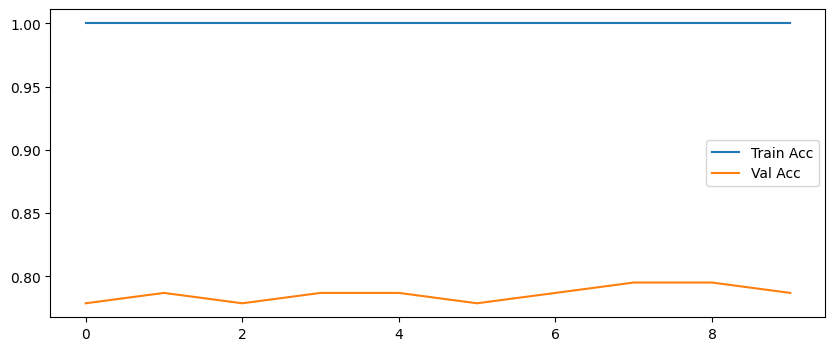

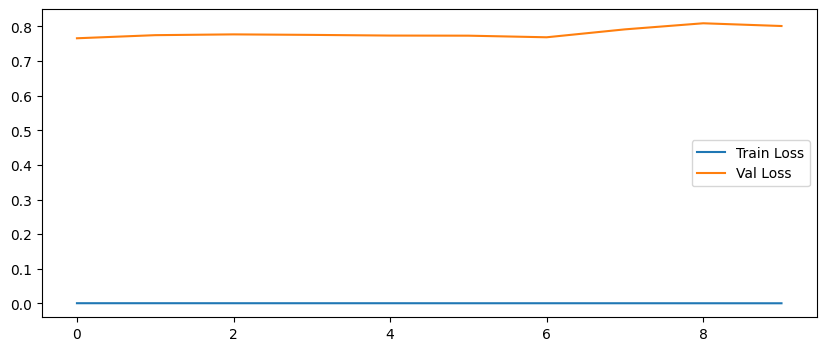

In [69]:
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()

# Step 4 — Prepare for the RNN Layer

**RNN layers expect input shaped as:**

(batch, timesteps, features)


**We wrap the pooled vector in an extra dimension so it becomes a sequence:**

(batch, 1, features)


This lets the GRU treat the spectrogram representation as a "time-aware" signal.

# Step 5 — Bidirectional GRU Layer (Temporal Modeling)

We use a Bidirectional GRU to learn how the sound evolves.

**Why GRU?**

It captures temporal structure (repetition, pitch glide, rhythm)

It understands patterns like barks repeating or meows rising

Bidirectional means it reads the sequence forward and backward

This layer gives the network temporal awareness — something CNN alone cannot do.

In [67]:
loss, acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {acc*100:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.7869 - loss: 0.8011
Validation Accuracy: 78.69%


In [68]:
def predict_audio(file_path):
    mel = load_mel_spectrogram(file_path)
    mel = np.expand_dims(mel, axis=0)

    pred = model.predict(mel)
    label = le.inverse_transform([np.argmax(pred)])
    return label[0]

test_file = "../data/cat/62ef962d_nohash_0.wav"
print("Prediction:", predict_audio(test_file))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Prediction: cat
